Import libraries:

In [31]:
import re
import nltk
import pandas as pd
import seaborn as sns

import winsound
import numpy as np
import pandas as pd
from tqdm import tqdm
from requests import get
import networkx as nx

from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from bs4.element import Comment
from bs4 import BeautifulSoup
import urllib.request

import collections
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from nltk import tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

Import CDFs:

In [2]:
def tags(x):
    return nltk.pos_tag(nltk.word_tokenize(x))[0][1]

def scoring(a,b):
    a = a.replace(',', '').split()
    b = b.replace(',', '').split()
    score = int(100*len(set(a).intersection(b))/(len(set(a))))
    return score

def tag_visible(element):
    if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
        return False
    if isinstance(element, Comment):
        return False
    return True

def text_normalize(txt):
    processed_text = re.sub('[^a-zA-Z]', ' ', txt)
    processed_text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",processed_text)
    processed_text=re.sub("(\\d|\\W)+"," ",processed_text)

    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(processed_text)
    
    tokens = [lemmatizer.lemmatize(word) for word in tokens if not word in stop_words]
    tokens = [i for i in tokens if (tags(i) in ['NN', 'NNP', 'NNS', 'NNPS'])]
    
    return tokens

def text_from_html(body):
    soup = BeautifulSoup(body, 'html.parser')
    texts = soup.findAll(text=True)
    visible_texts = filter(tag_visible, texts)  
    return u" ".join(t.strip() for t in visible_texts)

def parse_tds(url):
    htmlString = get(url).text

    soup = BeautifulSoup(htmlString, 'html.parser')
    title = soup.find('title')
    title_str = str(str(title.string).split('|', 1)[0])
    title_str = title_str.replace('Towards Data Science','')

    keywords = ', '.join([text_from_html(str(i)) for i in soup.find_all('a') if '/tagged' in str(i)]) + ', ' + title_str
    keywords = keywords.lower()
    return keywords

def parse_med(url):
    htmlString = get(url).text
    soup = BeautifulSoup(htmlString, 'html.parser')
    
    title_str = str(soup.find('h1').string)  
    keywords = ', '.join([text_from_html(str(i)) for i in soup.find_all('a') if '/tag/' in str(i)]) + ', ' + title_str
    keywords = keywords.lower()
    return keywords

def text_from_html(body):
    soup = BeautifulSoup(body, 'html.parser')
    texts = soup.findAll(text=True)
    visible_texts = filter(tag_visible, texts)  
    return u" ".join(t.strip() for t in visible_texts)

def create_graph(text, nodes=25, max_component=False, common=500):

    ## Normalize text
    tokens = text_normalize(text)
    ## /Normalize text

    ## create graph
    bigrams=list(nltk.ngrams(tokens, 2))
    bigram_counts = collections.Counter(bigrams)

    bigram_df = pd.DataFrame(bigram_counts.most_common(common), columns=['bigram', 'count'])
    d = bigram_df.set_index('bigram').T.to_dict('records')

    G = nx.Graph()
    for k, v in d[0].items():
            G.add_edge(k[0], k[1], weight=(v*10))
    ## /create graph

    ## show max connected component
    if max_component==True:
        G = max(connected_component_subgraphs(G), key=len)
        G = nx.dfs_tree(G)
    ## /show max connected component

    ## remove isolates
    G.remove_nodes_from(list(nx.isolates(G)))
    ## /remove isolates

    ## filter graph by degree
    threshold = int(G.number_of_nodes()*(max(nx.degree_centrality(G).values()))) #max centrality, nodes

    for i in range(0, threshold):
        F = nx.Graph() # empty graph
        fedges = filter(lambda x: G.degree()[x[0]] > 0 and G.degree()[x[1]] > i, G.edges())
        F.add_edges_from(fedges)
        F.remove_nodes_from(list(nx.isolates(F)))

        if F.number_of_nodes() < nodes:
            break
    ## /filter graph by degree

    pos = nx.spring_layout(F, iterations=500)

    return F, pos

def get_keys(url):
    
    ## parse url
    htmlString = get(url).text
    soup = BeautifulSoup(htmlString, 'html.parser')
    paragraphs = soup.find_all(['p', 'article', 'section', 'title', 'h1', 'h2', 'h3'])
    rawtext = text_from_html(str(paragraphs))
    ## /parse url
    
    ## nlp processing
    tokens = text_normalize(rawtext)
    ## /nlp processing

    ## Bigrams
    corpus = tokenize.sent_tokenize(' '.join(tokens))   
    vec = CountVectorizer(ngram_range=(2,2), max_features=100).fit(corpus)
    bag_of_words = vec.transform(corpus)

    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    keys_list_bg = [str(i[0]) for i in words_freq[:10]]
    ## /Bigrams

    # define keylist
    keys_list_bg = list(set(keys_list_bg))
    # /define keylist
    
    ## graph
    F,pos = create_graph(rawtext)
    d = dict(F.degree)
    keys_list_gr = [i[0] for i in sorted(F.degree, key=lambda x: x[1], reverse=True)][:5]
    ## /graph

    # mix keys
    keys_list = (keys_list_gr + keys_list_bg)
    keys_cap = (''.join([i.capitalize() for i in ' '.join(keys_list).split()])).split()
    # /mix keys

    keys = ', '.join(keys_list)
    
    return keys, rawtext

#### Add keys from web pages:

Get URLs:

In [3]:
pages_df = pd.read_excel(f'datasets/urls.xlsx', sheet_name='Sheet1')
pages_df.drop_duplicates(subset = 'url', keep = 'first', inplace = True)
pages_list = list(pages_df['url'])

Statistics:

In [4]:
len(pages_df)

298

Parse web pages:

In [ ]:
keys_list = []
web_list = []

for i in tqdm(pages_list[:]): 
    if 'towardsdatascience.com' in str(i):
            keys_list.append(parse_tds(i))
            web_list.append(i)
    elif 'medium.com' in str(i):
        keys_list.append(parse_med(i))
        web_list.append(i)
        
winsound.Beep(2500, 1000)        

Write do dataframe:

In [ ]:
df = pd.DataFrame(list(zip(web_list, keys_list)), columns=['url','tags'])
df.to_excel (r'datasets/keys.xlsx', index = False, header=True)
df.head()

Statistics:

In [ ]:
print('Number of records:', len(df))

#### Add ML keys:

Read urls:

In [ ]:
df_urls = pd.read_excel(r'datasets/keys.xlsx', sheet_name='Sheet1')
tag_list = list(df_urls['tags'])
pages_list = list(df_urls['url'])
df_urls.head()

Statistics:

In [ ]:
len(df_urls)

Get ML keys:

In [ ]:
keys_list = []
web_list = []
text_list = []

for i in tqdm(pages_list):   
    keys, text = get_keys(i)    
    
    keys_list.append(keys)
    text_list.append(text)
    web_list.append(i)
    
winsound.Beep(2500, 1000)   

Write tags and keys to df:

In [ ]:
df = pd.DataFrame(list(zip(web_list, tag_list, text_list, keys_list)), columns=['url','tags','text','keys'])
df.to_excel (r'datasets/keys_full.xlsx', index = False, header=True)
df.head(20)

#### Similarity analysis

Define score:

In [5]:
df = pd.read_excel(r'datasets/dataset.xlsx', sheet_name='Sheet1')
df['score'] = df.apply(lambda x: scoring(x['tags'], x['keys']), axis=1)
df.head()

,url,tags,text,keys,score
0,https://towardsdatascience.com/text-summarizat...,"deep learning, text summarization, encoder dec...",Text Summarization from scratch using Encoder-...,"sequence, decoder, word, input, output, percen...",25
1,https://towardsdatascience.com/simple-text-sum...,"naturallanguageprocessing, web scraping, text ...",Simple Text Summarizer Using Extractive Method...,"word, sent, article, sentence, summary, number...",7
2,https://towardsdatascience.com/text-summarizat...,"glove, lstm, text summarization, encoder decod...",Text Summarization with GloVe Embeddings.. Tex...,"layer, matrix, embeddings, word, vector, decod...",80
3,https://towardsdatascience.com/lets-give-some-...,"lstm, encoder decoder, text summarization, att...",Let’s give some ‘Attention’ to Summarising Tex...,"word, sequence, summary, model, Attention, out...",28
4,https://towardsdatascience.com/automatic-text-...,"nlp, text summarization, textrank, automatic t...",Automatic Text Summarisation Condensing custom...,"text, PageRank, TextRank, similarity, matrix, ...",10


Write new dataframe:

In [6]:
df.to_excel (r'datasets/scoring.xlsx', index = False, header=True)
df.head()

,url,tags,text,keys,score
0,https://towardsdatascience.com/text-summarizat...,"deep learning, text summarization, encoder dec...",Text Summarization from scratch using Encoder-...,"sequence, decoder, word, input, output, percen...",25
1,https://towardsdatascience.com/simple-text-sum...,"naturallanguageprocessing, web scraping, text ...",Simple Text Summarizer Using Extractive Method...,"word, sent, article, sentence, summary, number...",7
2,https://towardsdatascience.com/text-summarizat...,"glove, lstm, text summarization, encoder decod...",Text Summarization with GloVe Embeddings.. Tex...,"layer, matrix, embeddings, word, vector, decod...",80
3,https://towardsdatascience.com/lets-give-some-...,"lstm, encoder decoder, text summarization, att...",Let’s give some ‘Attention’ to Summarising Tex...,"word, sequence, summary, model, Attention, out...",28
4,https://towardsdatascience.com/automatic-text-...,"nlp, text summarization, textrank, automatic t...",Automatic Text Summarisation Condensing custom...,"text, PageRank, TextRank, similarity, matrix, ...",10


Statistics:

In [8]:
print('Median score:', int(np.median(df['score'])), '%')
print('Score scattering:', int((np.max(df['score'])-np.min(df['score']))/2), '%')

Median score: 18 %
Score scattering: 40 %


#### Keywword distribution:

Vectorize text:

In [42]:
df.dropna(inplace=True)
corpus = list(df['text'])
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\skamenshchikov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


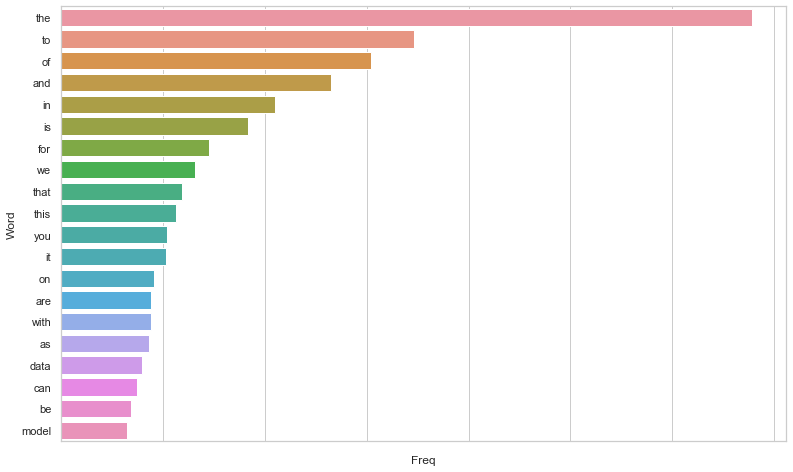

In [55]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]

sns.set(rc={'figure.figsize':(13,8)})
sns.set(style="whitegrid")
g = sns.barplot(x="Freq", y="Word", data=top_df)
settings = g.set_xticklabels(g.get_xticklabels(), rotation=30)
g.figure.savefig("hist.png")